In [1]:
from __future__ import print_function, division

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import os

In [4]:
import context
from hier_clust import HierClust
from hier_clust.tree_util import Tree

In [5]:
from impurity_utils import (
    construct_random_tree,
    convert_linkage_to_tree,
    random_leaf_impurity,
    avg_gini_impurity_tree,
    avg_gini_impurity_from_assignments,
    gini_impurity_single_node,
    add_counters_to_tree,
)

In [6]:
import scipy.cluster.hierarchy as sch

In [7]:
import pandas as pd

In [8]:
from sklearn import preprocessing

In [9]:
base_dir = "/Users/aleverentz/Downloads/abalone"

In [10]:
column_names = [
  "sex",
  "length",
  "diameter",
  "height",
  "whole_weight",
  "shucked_weight",
  "viscera_weight",
  "shell_weight",
  "rings",
]

Data source: UCI "Abalone" dataset (https://archive.ics.uci.edu/ml/datasets/Abalone)

In [11]:
filename = os.path.join(base_dir, "abalone.data")
df = pd.read_csv(filename, header=None, names=column_names)

In [12]:
sexes = ["M", "F", "I"]

In [13]:
df["sex"] = map(lambda x: sexes.index(x), df["sex"])

In [14]:
n_obs = df.shape[0]

In [15]:
x = np.asarray(df.iloc[:n_obs, :-1])
y = np.asarray(df.iloc[:n_obs, -1])

In [16]:
x = preprocessing.scale(x)

In [17]:
print(x.shape)
print(y.shape)

(4177, 8)
(4177,)


In [18]:
%%time
h_obj = HierClust()
tree, _ = h_obj.fit(x)

/usr/local/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


CPU times: user 18.5 s, sys: 386 ms, total: 18.9 s
Wall time: 19 s


In [19]:
trees = dict()
top_down_label = "Top Down"
trees[top_down_label] = tree

In [20]:
assignments_pruned = h_obj._get_assignments(tree.prune(depth=3))
avg_gini_impurity_from_assignments(assignments_pruned, labels=y)

0.85135378968023

In [21]:
tree = add_counters_to_tree(tree, y)
#print tree.prune(3).str_display()
avg_gini_impurity_tree(tree.prune(3))

0.8513537896802298

In [22]:
import timeit
def create_timer():
    start = timeit.default_timer()
    def timer():
        return timeit.default_timer() - start
    return timer

In [23]:
#methods = ["single", "average", "complete", "ward"]
methods = ["average", "complete", "ward"]

for method in methods:
    timer = create_timer()
    print("Starting method: {}".format(method))
    try:
        link = sch.linkage(x, method=method)
    except Exception as e:
        print("Exception during clustering: {}".format(e))
    try:
        trees["BU ({})".format(method)] = convert_linkage_to_tree(link, labels = y)
    except Exception as e:
        print("Exception during post-processing: {}".format(e))
    print("Method '{}' elapsed time: {} seconds".format(method, timer()))

Starting method: average
Method 'average' elapsed time: 24.4663069248 seconds
Starting method: complete
Method 'complete' elapsed time: 24.8267478943 seconds
Starting method: ward
Method 'ward' elapsed time: 22.1285319328 seconds


In [24]:
%%time
np.random.seed(1)
random_tree = construct_random_tree(indices = np.arange(len(y)))
random_tree = add_counters_to_tree(random_tree, labels=y)
trees["Random 50% split"] = random_tree

CPU times: user 299 ms, sys: 6.51 ms, total: 305 ms
Wall time: 303 ms


BU (average)
BU (complete)
BU (ward)
Random 50% split
Top Down
CPU times: user 2.61 s, sys: 65.5 ms, total: 2.67 s
Wall time: 2.8 s


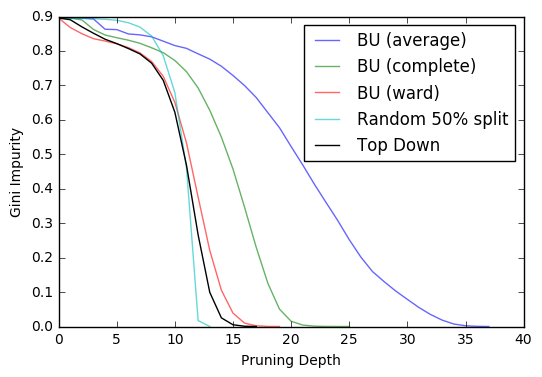

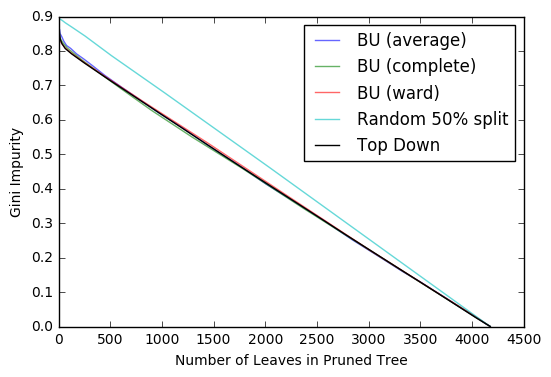

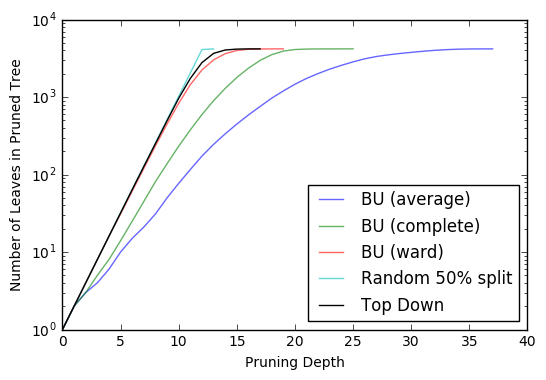

In [25]:
%%time

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

depths = np.arange(n_obs)
for name in sorted(trees.keys()):
    print(name)
    tree = trees[name]
    total_leaves = tree.num_leaves()
    list_num_leaves = []
    impurity = []
    depths_used = []
    for d in depths:
        pruned_tree = tree.prune(depth = d)
        impurity.append(avg_gini_impurity_tree(pruned_tree))
        num_leaves = pruned_tree.num_leaves()
        list_num_leaves.append(num_leaves)
        depths_used.append(d)
        if num_leaves == total_leaves:
            break
    if name == top_down_label:
        kw = dict(alpha=1.0, color='black')
    else:
        kw = dict(alpha = 0.6)
    ax1.plot(depths_used, impurity, label=name, **kw)
    ax2.plot(list_num_leaves, impurity, label=name, **kw)
    ax3.semilogy(depths_used, list_num_leaves, label=name, **kw)

ax1.legend(loc='best')
ax1.set_ylabel('Gini Impurity')
ax1.set_xlabel('Pruning Depth')

ax2.legend(loc='best')
ax2.set_ylabel('Gini Impurity')
ax2.set_xlabel('Number of Leaves in Pruned Tree')

ax3.legend(loc='best')
ax3.set_ylabel('Number of Leaves in Pruned Tree')
ax3.set_xlabel('Pruning Depth')

None